# Modeling and Simulation in Python

Milestone: Queueing theory

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Title

In [2]:
def make_system(lam, mu):
    return System(lam=lam, mu=mu,
                  x=0, duration=8*60)

In [3]:
interarrival_time = 8
service_time = 5

lam = 1 / interarrival_time
mu = 1 / service_time

system = make_system(lam, mu)
system

,value
lam,0.125
mu,0.200
x,0.000
duration,480.000


In [4]:
def update_func1(system):
    """Simulate one time step.
    
    system: System object
    """
    # if there's a customer in service, check if they're done
    if system.x > 0:
        if flip(system.mu):
            system.x -= 1
            
    # check for an arrival
    if flip(system.lam):
        system.x += 1

In [5]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    
    results = TimeSeries()
    
    for t in linrange(0, system.duration-1):
        update_func(system)
            
        results[t] = system.x
        
    system.results = results
    system.L = results.mean()
    system.W = system.L / system.lam

0.4625 3.7


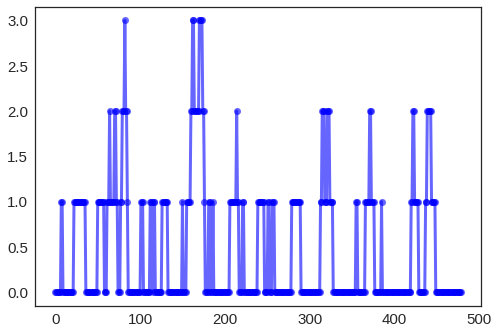

In [6]:
run_simulation(system, update_func1)
print(system.L, system.W)
plot(system.results)

In [7]:
mu = 1 / service_time
num_vals = 51
lam_array = linspace(0.1*mu, 0.8*mu, num_vals)
print(mu)
lam_array

0.2


array([ 0.02  ,  0.0214,  0.0228,  0.0242,  0.0256,  0.027 ,  0.0284,
        0.0298,  0.0312,  0.0326,  0.034 ,  0.0354,  0.0368,  0.0382,
        0.0396,  0.041 ,  0.0424,  0.0438,  0.0452,  0.0466,  0.048 ,
        0.0494,  0.0508,  0.0522,  0.0536,  0.055 ,  0.0564,  0.0578,
        0.0592,  0.0606,  0.062 ,  0.0634,  0.0648,  0.0662,  0.0676,
        0.069 ,  0.0704,  0.0718,  0.0732,  0.0746,  0.076 ,  0.0774,
        0.0788,  0.0802,  0.0816,  0.083 ,  0.0844,  0.0858,  0.0872,
        0.0886,  0.09  ,  0.0914,  0.0928,  0.0942,  0.0956,  0.097 ,
        0.0984,  0.0998,  0.1012,  0.1026,  0.104 ,  0.1054,  0.1068,
        0.1082,  0.1096,  0.111 ,  0.1124,  0.1138,  0.1152,  0.1166,
        0.118 ,  0.1194,  0.1208,  0.1222,  0.1236,  0.125 ,  0.1264,
        0.1278,  0.1292,  0.1306,  0.132 ,  0.1334,  0.1348,  0.1362,
        0.1376,  0.139 ,  0.1404,  0.1418,  0.1432,  0.1446,  0.146 ,
        0.1474,  0.1488,  0.1502,  0.1516,  0.153 ,  0.1544,  0.1558,
        0.1572,  0.1

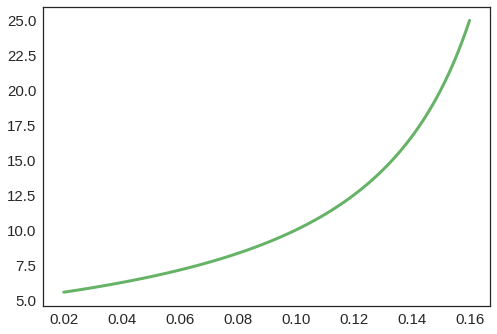

In [8]:
def plot_W(lam_array, mu):
    W = 1 / (mu - lam_array)
    plot(lam_array, W, 'g-')
    
plot_W(lam_array, mu)

In [20]:
def sweep_lam(lam_array, mu, update_func):
    """Run simulations with a range of values for `lam`
    
    Plots wait time, W, versus lam, and
    prints the average of W across runs.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    update_func: passed along to run_simulation
    """
    total = 0
    for lam in lam_array:
        system = make_system(lam, mu)
        run_simulation(system, update_func)
        total += system.W
        plot(lam, system.W)
        
    W_avg = total / len(lam_array)
    print('Average of averages = ', W_avg, 'minutes')

Average of averages =  8.96148013633


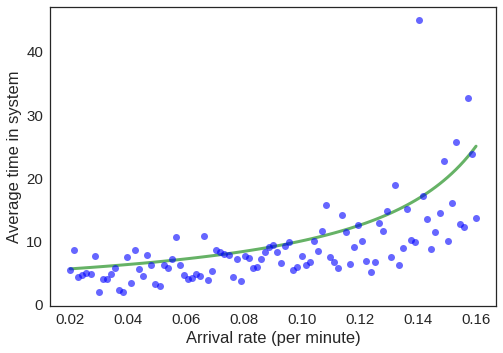

In [10]:
plot_W(lam_array, mu)

sweep_lam(lam_array, mu, update_func1)

decorate(xlabel='Arrival rate (per minute)',
         ylabel='Average time in system')

In [11]:
def update_func2(system):
    """Simulate a single queue with two servers.
    
    system: System object
    """
    # if both servers are busy, check whether the
    # second is complete
    if system.x > 1 and flip(system.mu):
        system.x -= 1
            
    # check whether the first is complete
    if system.x > 0 and flip(system.mu):
        system.x -= 1
            
    if flip(system.lam):
        system.x += 1

0.5416666666666666 4.33333333333


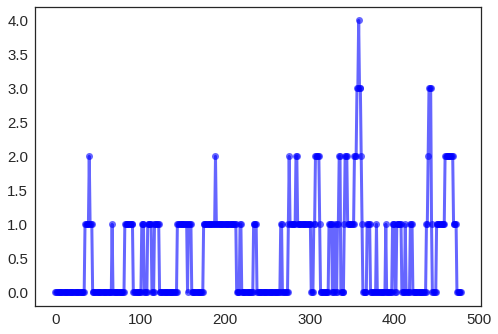

In [12]:
system = make_system(lam, mu)
run_simulation(system, update_func2)
print(system.L, system.W)
plot(system.results)

In [13]:
lam_array = linspace(0.1*mu, 1.6*mu, num_vals)

Average of averages =  6.27772135702


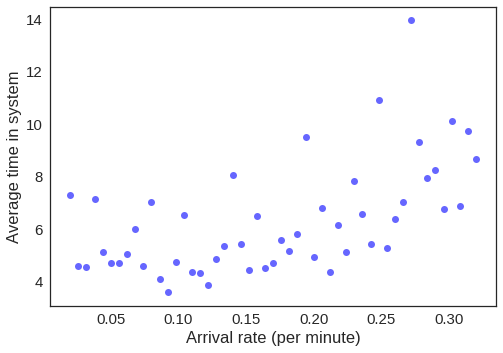

In [14]:
sweep_lam(lam_array, mu, update_func2)

decorate(xlabel='Arrival rate (per minute)',
         ylabel='Average time in system')

In [16]:
def update_func3(system):
    """Simulate two queues with one server each.
    
    system: System object
    """
    # if the first servers is busy, check it it's done
    if system.q1 > 0 and flip(system.mu):
        system.q1 -= 1
            
    # if the second queue is busy, check if it's done
    if system.q2 > 0 and flip(system.mu):
        system.q2 -= 1
            
    # check for an arrival
    if flip(system.lam):
        # join whichever queue is shorter
        if system.q1 < system.q2:
            system.q1 += 1
        else:
            system.q2 += 1
            
    system.x = system.q1 + system.q2

In [17]:
def make_system(lam, mu):
    return System(lam=lam, mu=mu,
                  x=0, duration=8*60,
                  q1=0, q2=0)

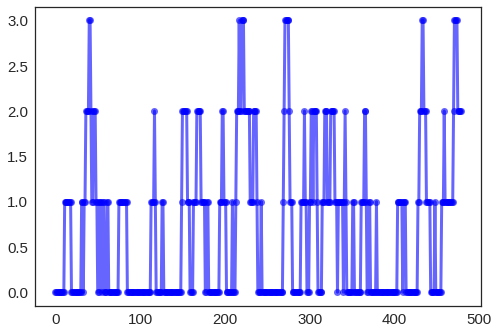

In [18]:
system = make_system(lam, mu)
run_simulation(system, update_func3)
plot(system.results)

Average of averages =  6.52783949641 minutes


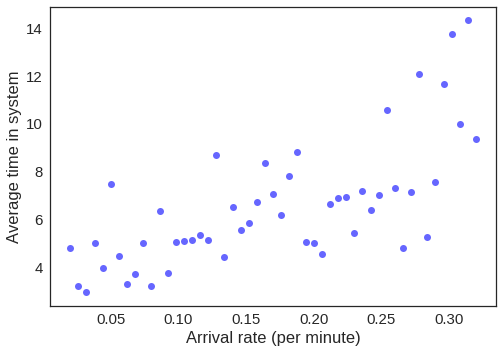

In [21]:
sweep_lam(lam_array, mu, update_func3)

decorate(xlabel='Arrival rate (per minute)',
         ylabel='Average time in system')